# Data Preprocessing steps

- Spatial Encoding: Done
- Random Oversampling to correct class balance: Done
- Lag Features + Accelerated Target for forecasting model: TODO
    - Encode Lag features from 4 weeks previous
    - Make target variable the score for X weeks out

In [1]:
import pandas as pd
import json
from functools import lru_cache

rounded_train = pd.read_csv('../data/train_with_rounded_score.csv')
rounded_test = pd.read_csv('../data/test_with_rounded_score.csv')
raw_train = pd.read_csv('../data/train_with_raw_score.csv')
raw_test = pd.read_csv('../data/test_with_raw_score.csv')
fips_map = open('../data/fips_map.json')
fips_map = json.load(fips_map)

@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(fips_code)
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]


In [2]:
def replace_fips(df):
    coords = pd.DataFrame(df['fips'].apply(fips_to_coordinate).tolist(), columns=['lat', 'long'])
    df = pd.concat([df, coords], axis=1)
    df = df.drop(['fips'], axis=1)
    return df

# Attempt 1: Training a Catboost Regressor with no feature engineering other than spatial encoding. 

- I want to see what the performance of the model is with just spatial encoding. This does not incorporate any lag features, or do any forecasting, but is intended to be a baseline off of which we can tune the regressive models needed for future use.

In [20]:
train = raw_train.copy()
test = raw_test.copy()

train = replace_fips(train)
test = replace_fips(test)

train = train.drop(['date'],axis=1)
test = test.drop(['date'],axis=1)

In [21]:
from catboost import CatBoostRegressor


model = CatBoostRegressor()
model.fit(train.drop(['score'], axis=1), train['score'])

Learning rate set to 0.143141
0:	learn: 1.2020214	total: 236ms	remaining: 3m 56s
1:	learn: 1.1854770	total: 477ms	remaining: 3m 57s
2:	learn: 1.1722514	total: 734ms	remaining: 4m 4s
3:	learn: 1.1618601	total: 1s	remaining: 4m 9s
4:	learn: 1.1534296	total: 1.25s	remaining: 4m 8s
5:	learn: 1.1461779	total: 1.5s	remaining: 4m 8s
6:	learn: 1.1402717	total: 1.75s	remaining: 4m 8s
7:	learn: 1.1359029	total: 2.01s	remaining: 4m 9s
8:	learn: 1.1321657	total: 2.26s	remaining: 4m 9s
9:	learn: 1.1288927	total: 2.52s	remaining: 4m 9s
10:	learn: 1.1257840	total: 2.77s	remaining: 4m 9s
11:	learn: 1.1233268	total: 3.05s	remaining: 4m 11s
12:	learn: 1.1213900	total: 3.27s	remaining: 4m 8s
13:	learn: 1.1193193	total: 3.53s	remaining: 4m 8s
14:	learn: 1.1173403	total: 3.8s	remaining: 4m 9s
15:	learn: 1.1159604	total: 4.03s	remaining: 4m 7s
16:	learn: 1.1142209	total: 4.29s	remaining: 4m 8s
17:	learn: 1.1129553	total: 4.55s	remaining: 4m 8s
18:	learn: 1.1114891	total: 4.8s	remaining: 4m 7s
19:	learn: 1.1

In [22]:
model_pred = model.predict(test.drop(['score'], axis=1))

In [23]:
pd.Series(model_pred).round().astype(int).value_counts()

 1    148292
 0    140608
 2     34168
 3      2904
 4       329
-1        24
 5        15
dtype: int64

Text(0, 0.5, 'score')

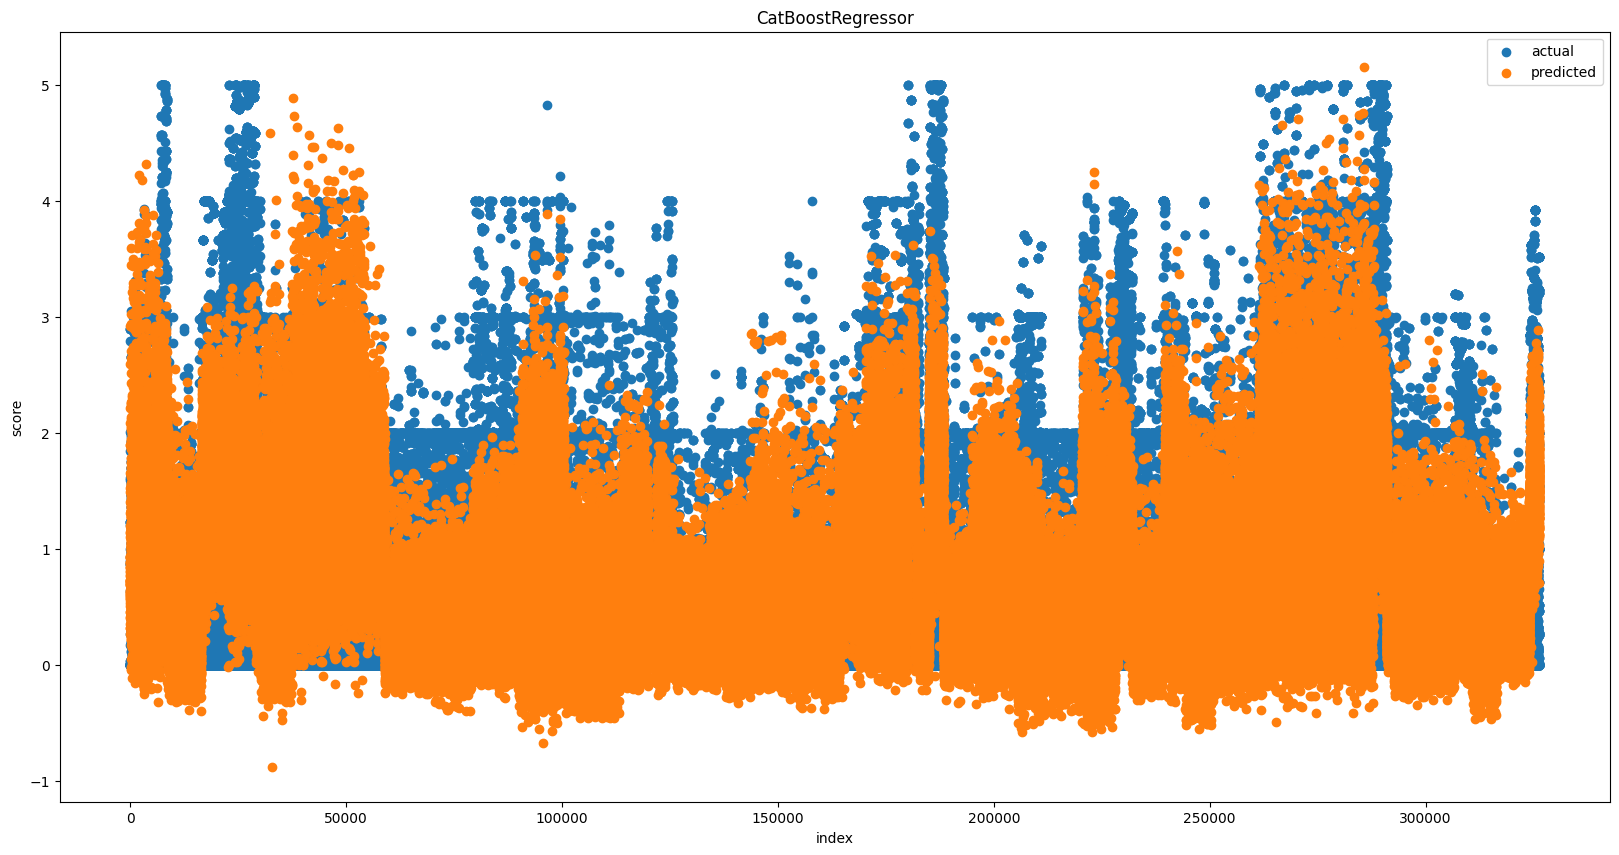

In [44]:
# plot score vs index of test set

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, model_pred)
plt.title('CatBoostRegressor')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')

Text(0, 0.5, 'Predicted score')

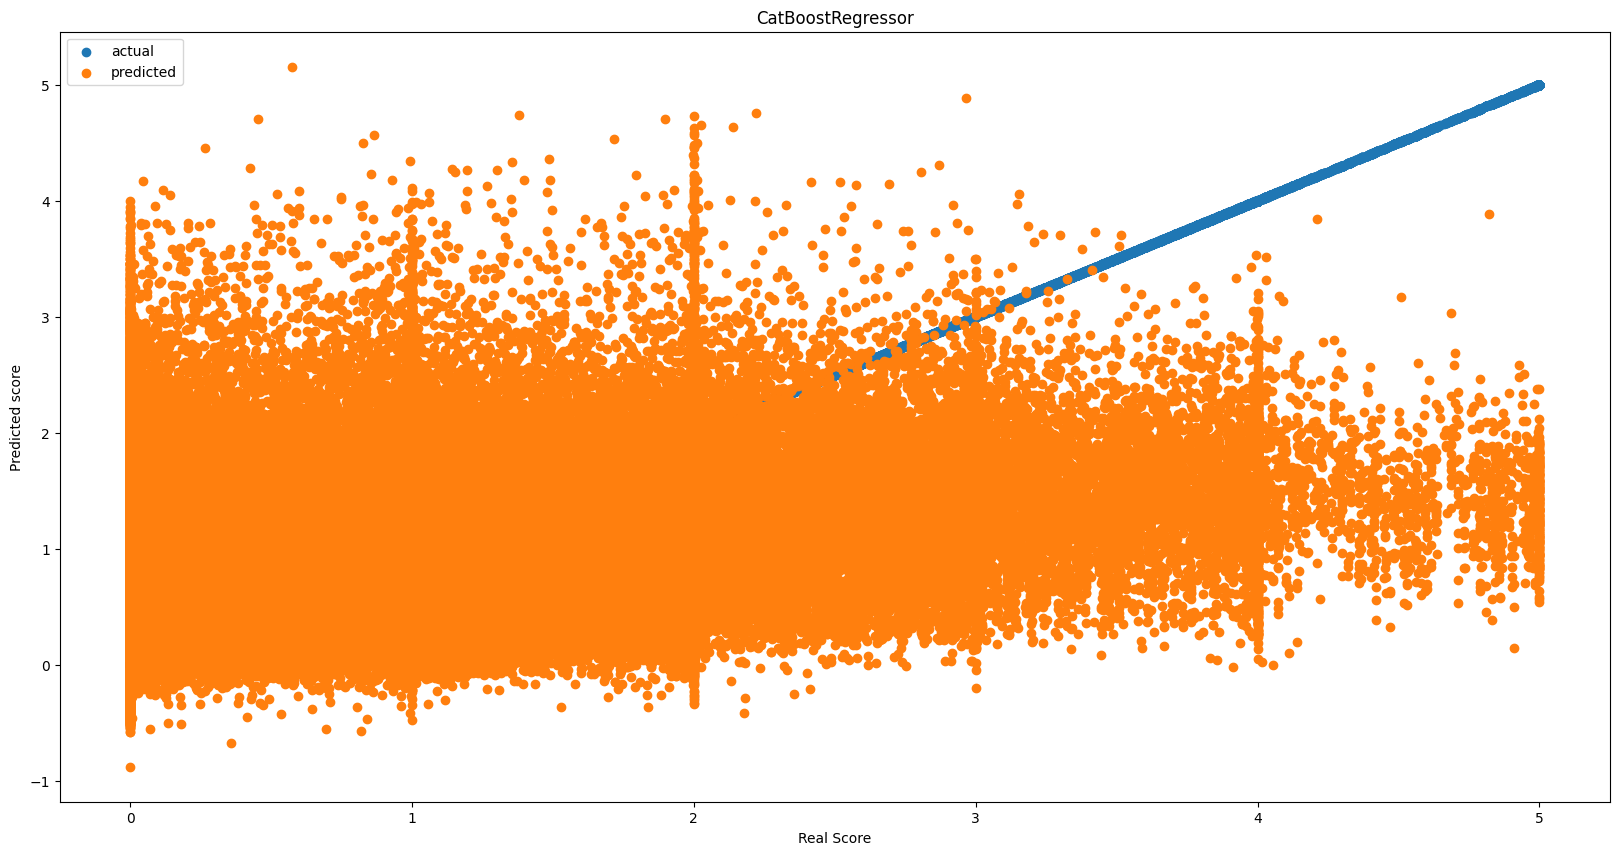

In [97]:

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test['score'], test['score'])
plt.scatter(test['score'], model_pred)
plt.title('CatBoostRegressor')
plt.legend(['actual', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted score')

In [88]:
# Check MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, r2_score

print("Mean Squared Error: ", mean_squared_error(test['score'], model_pred))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], model_pred))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], model_pred))
print("R2 Score: ", r2_score(test['score'], model_pred))

Mean Squared Error:  0.7646419217106
Mean Absolute Error:  0.6704698094839872
Mean Absolute Percentage Error:  1810587988628717.0
R2 Score:  -0.0878119558467616


In [63]:
#save cb regressor model
import pickle
pickle.dump(model,open('../models/catboost_regressor1_regressionexperiments.pkl', 'wb'))

This model is fitting decently, but the MSE is still 0.76. When the differences between two classes are 1, this can be a big problem. We can see from the scatterplot that we are able to do decently on the lower scores, but the higher scores are not being predicted well. Incorporate a lag feature may help with this, as higher classes are intuitively more likely to be predicted by the previous week's score, since the "droughtness" likely builds over time.

We may also need to try different models beyond catboost, or additional feature engineering such as PCA or feature scaling to reduce variance and dimensionality.

# Attempt 2: Trying an MLP Regressor

I want to train an MLP Regressor and compare it with the CatBoostRegressor

In [27]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=10000)

In [28]:
mlp_model.fit(train.drop(['score'], axis=1), train['score'])

MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=10000)

In [32]:
mlp_pred = mlp_model.predict(test.drop(['score'], axis=1))

Text(0, 0.5, 'score')

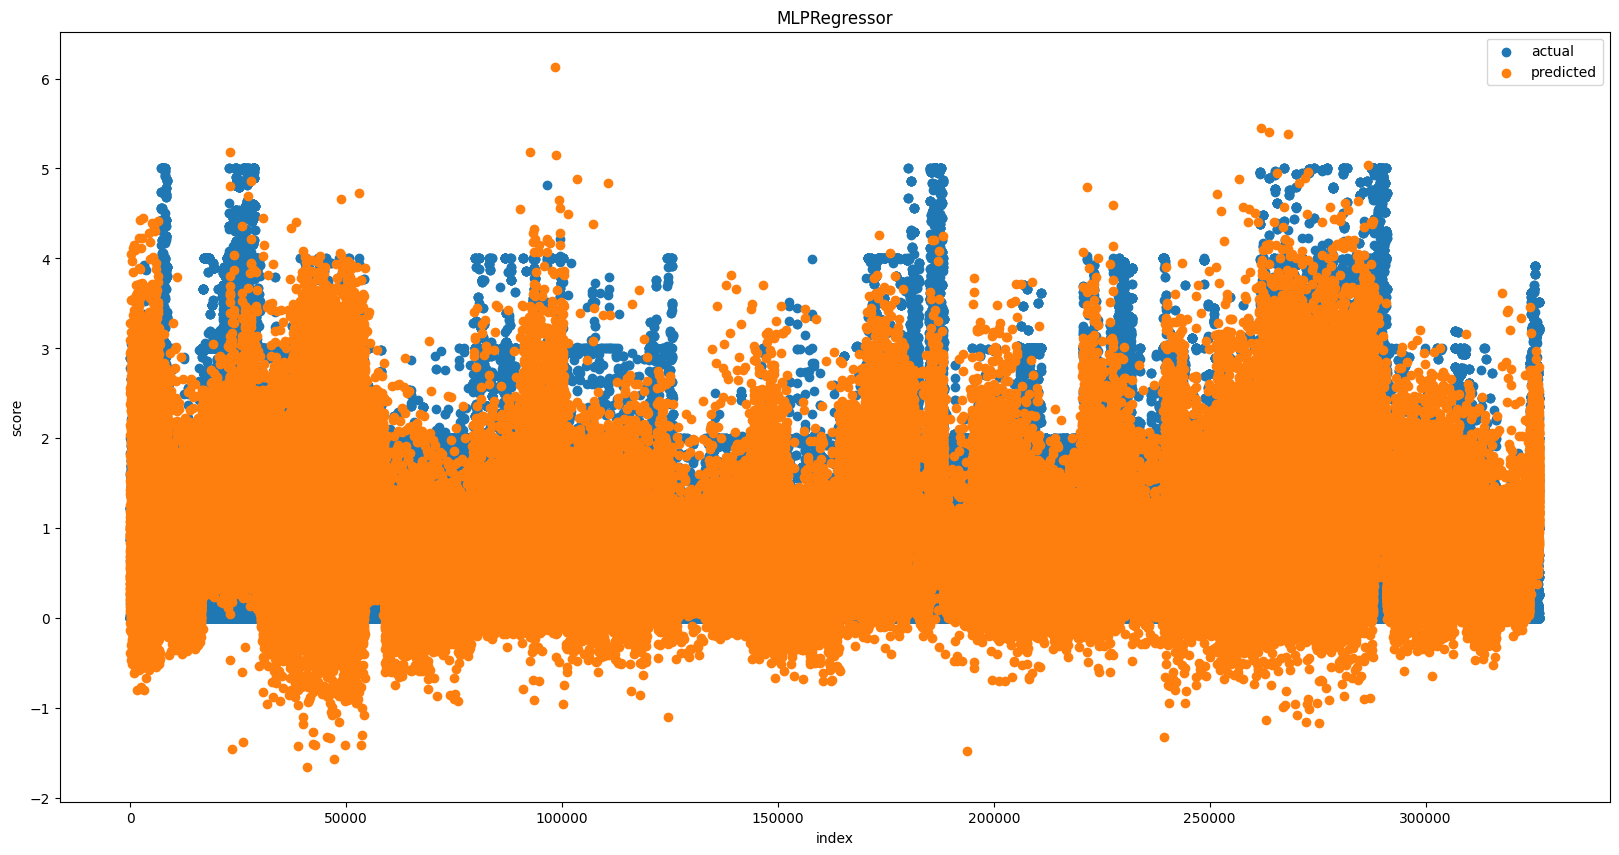

In [45]:
# plot score vs index of test set

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, mlp_pred)
plt.title('MLPRegressor')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')

Text(0, 0.5, 'score')

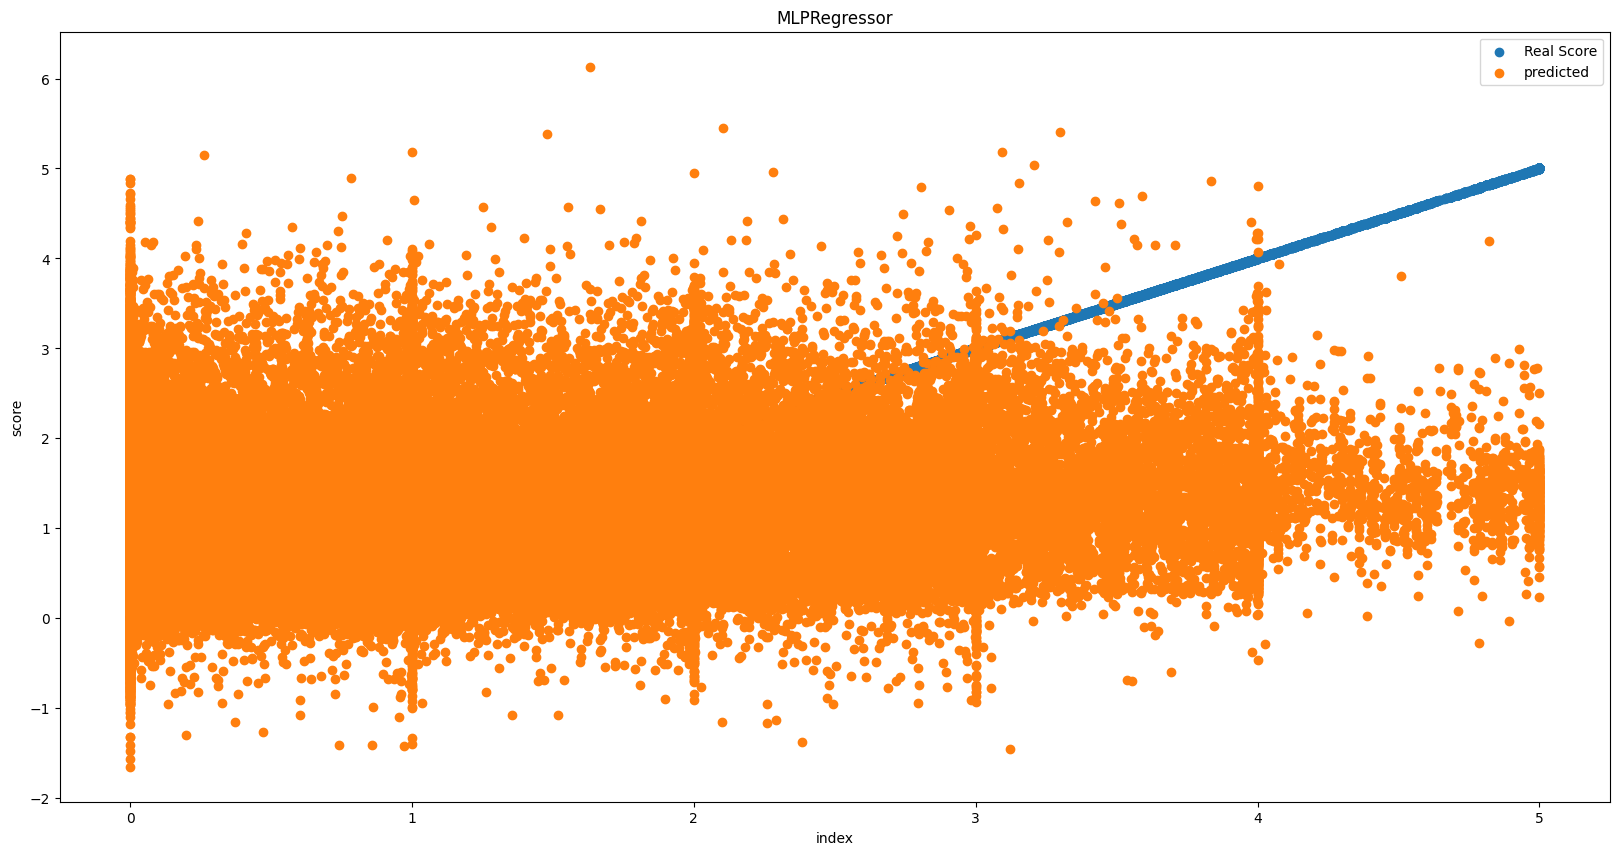

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test['score'], test['score'])
plt.scatter(test['score'], mlp_pred)
plt.title('MLPRegressor')
plt.legend(['Real Score', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted Score')

In [89]:
# Check MSE
from sklearn.metrics import mean_squared_error
print("Mean Squared Error: ", mean_squared_error(test['score'], mlp_pred))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], mlp_pred))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], mlp_pred))
print("R2 Score: ", r2_score(test['score'], mlp_pred))

Mean Squared Error:  0.8117843878126008
Mean Absolute Error:  0.6694848351652255
Mean Absolute Percentage Error:  1755597196297678.8
R2 Score:  -0.1548788230924556


The MSE of the MLP Regressor is worse, but it is capturing higher classes better. We can try to tune the MLP Regressor, or do some post-processing to the predictions to make them more accurate.

Truncating predictions of both to be within the range.

In [36]:
#truncate predictions to be between 0 and 5
mlp_pred_truncated = mlp_pred.copy()
mlp_pred_truncated[mlp_pred_truncated < 0] = 0
mlp_pred_truncated[mlp_pred_truncated > 5] = 5

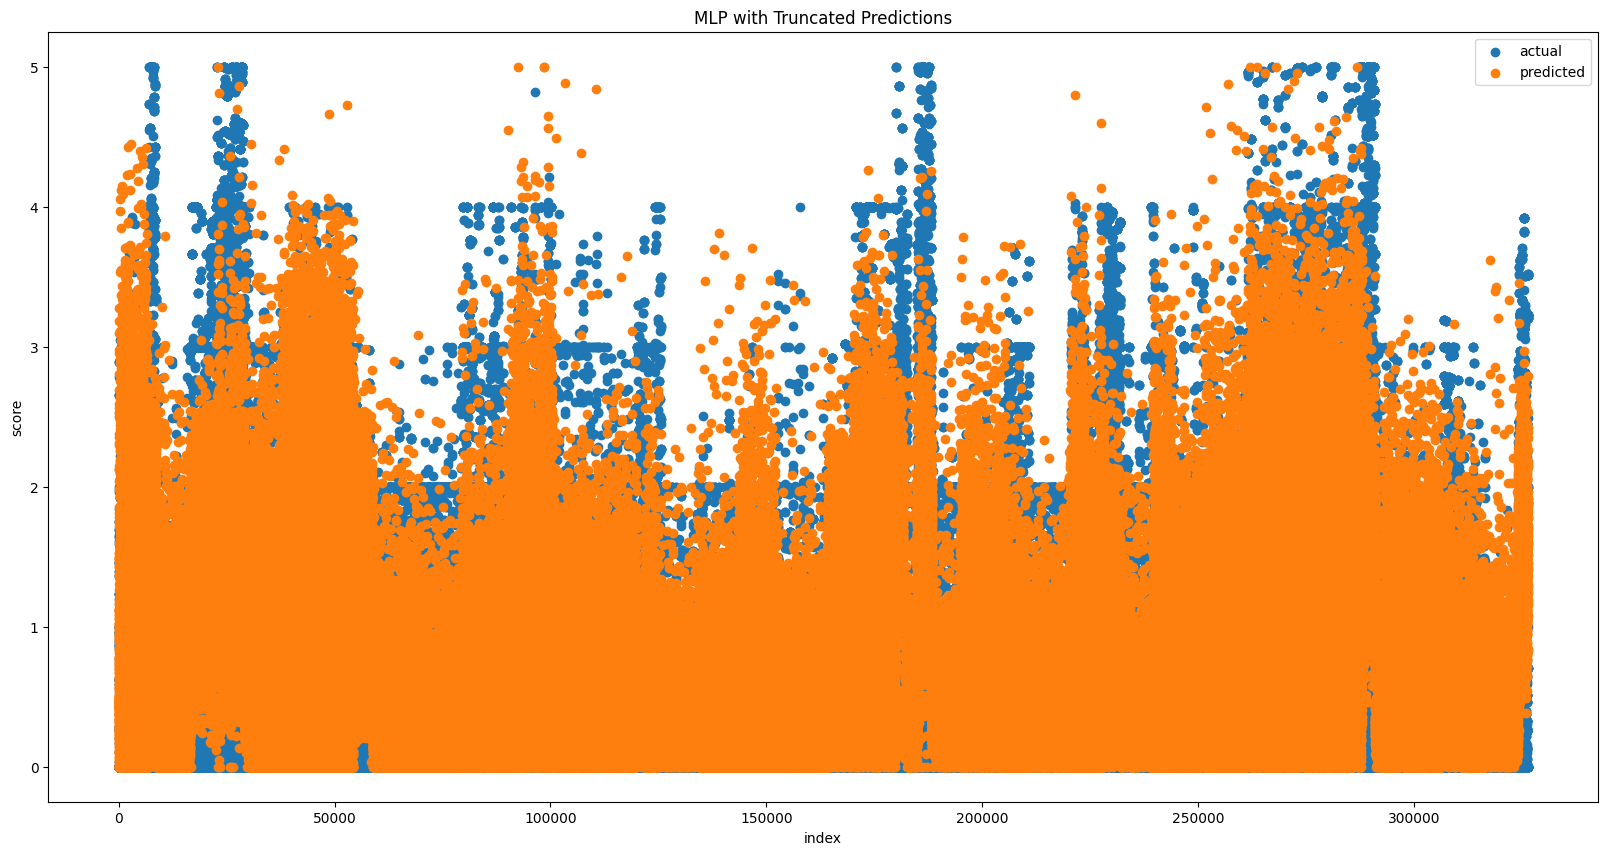

Mean Squared Error:  0.8082317729812724
Mean Absolute Error:  0.6664472940114372
Mean Absolute Percentage Error:  1746060330185975.8
R2 Score:  -0.1498247228942975


In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, mlp_pred_truncated)
plt.title('MLP with Truncated Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('Index')
plt.ylabel('Score')
plt.show()

# Check MSE
from sklearn.metrics import mean_squared_error
print("Mean Squared Error: ", mean_squared_error(test['score'], mlp_pred_truncated))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], mlp_pred_truncated))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], mlp_pred_truncated))
print("R2 Score: ", r2_score(test['score'], mlp_pred_truncated))


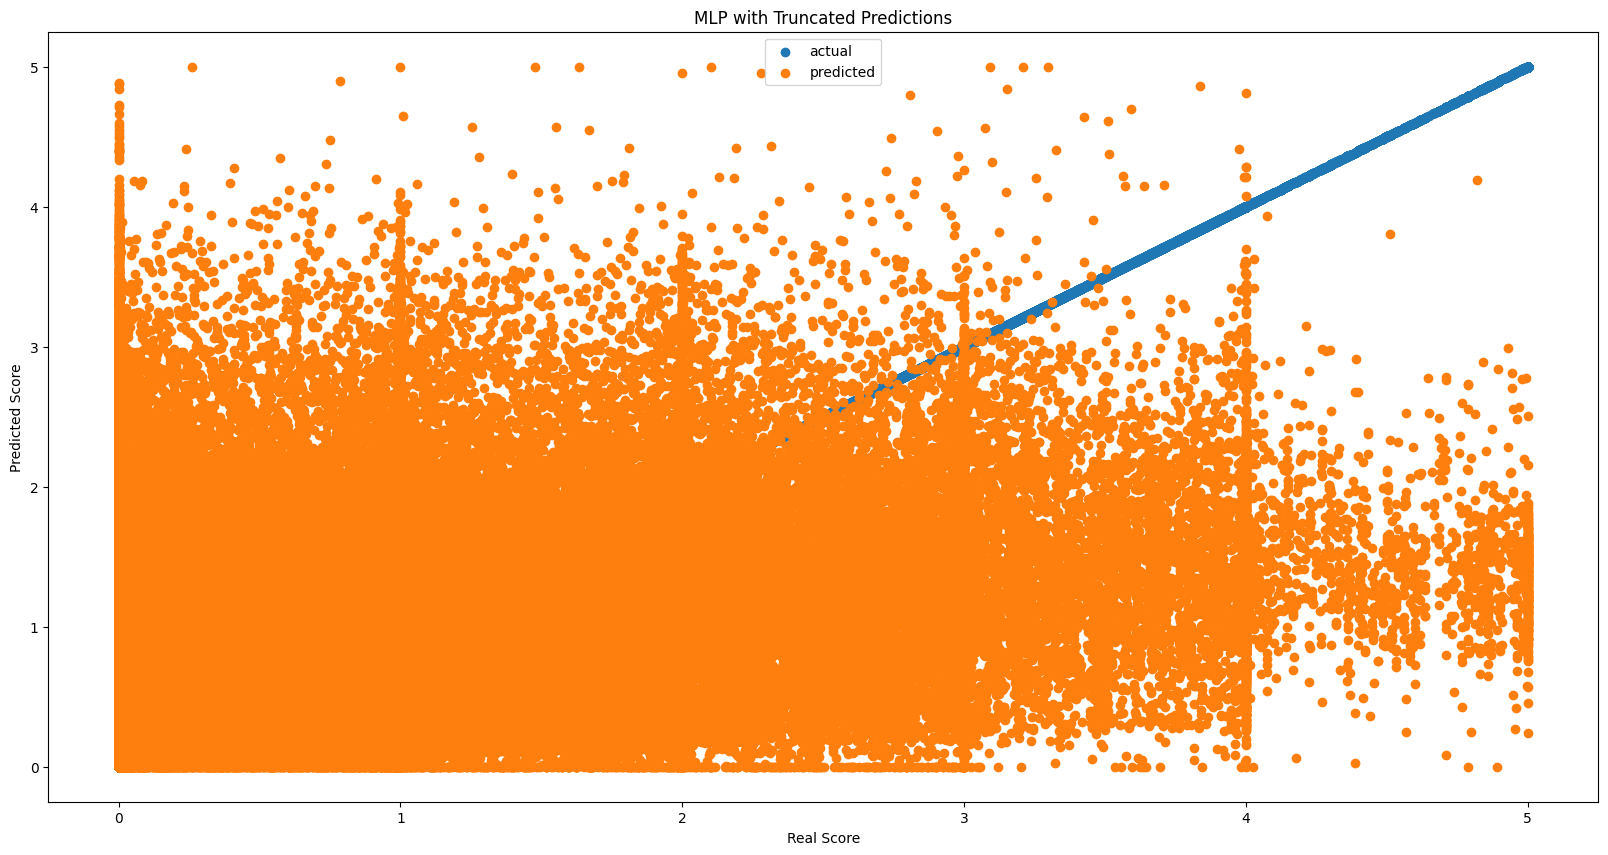

In [99]:
plt.figure(figsize=(20,10))
plt.scatter(test['score'], test['score'])
plt.scatter(test['score'], mlp_pred_truncated)
plt.title('MLP with Truncated Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted Score')
plt.show()

In [39]:
#save the mlp model
import pickle
pickle.dump(mlp_model, open('../models/mlp_regression_rawTrainSpatial.pkl', 'wb'))

In [40]:
#truncate predictions to be between 0 and 5
model_pred_truncated = model_pred.copy()
model_pred_truncated[model_pred < 0] = 0
model_pred_truncated[model_pred > 5] = 5

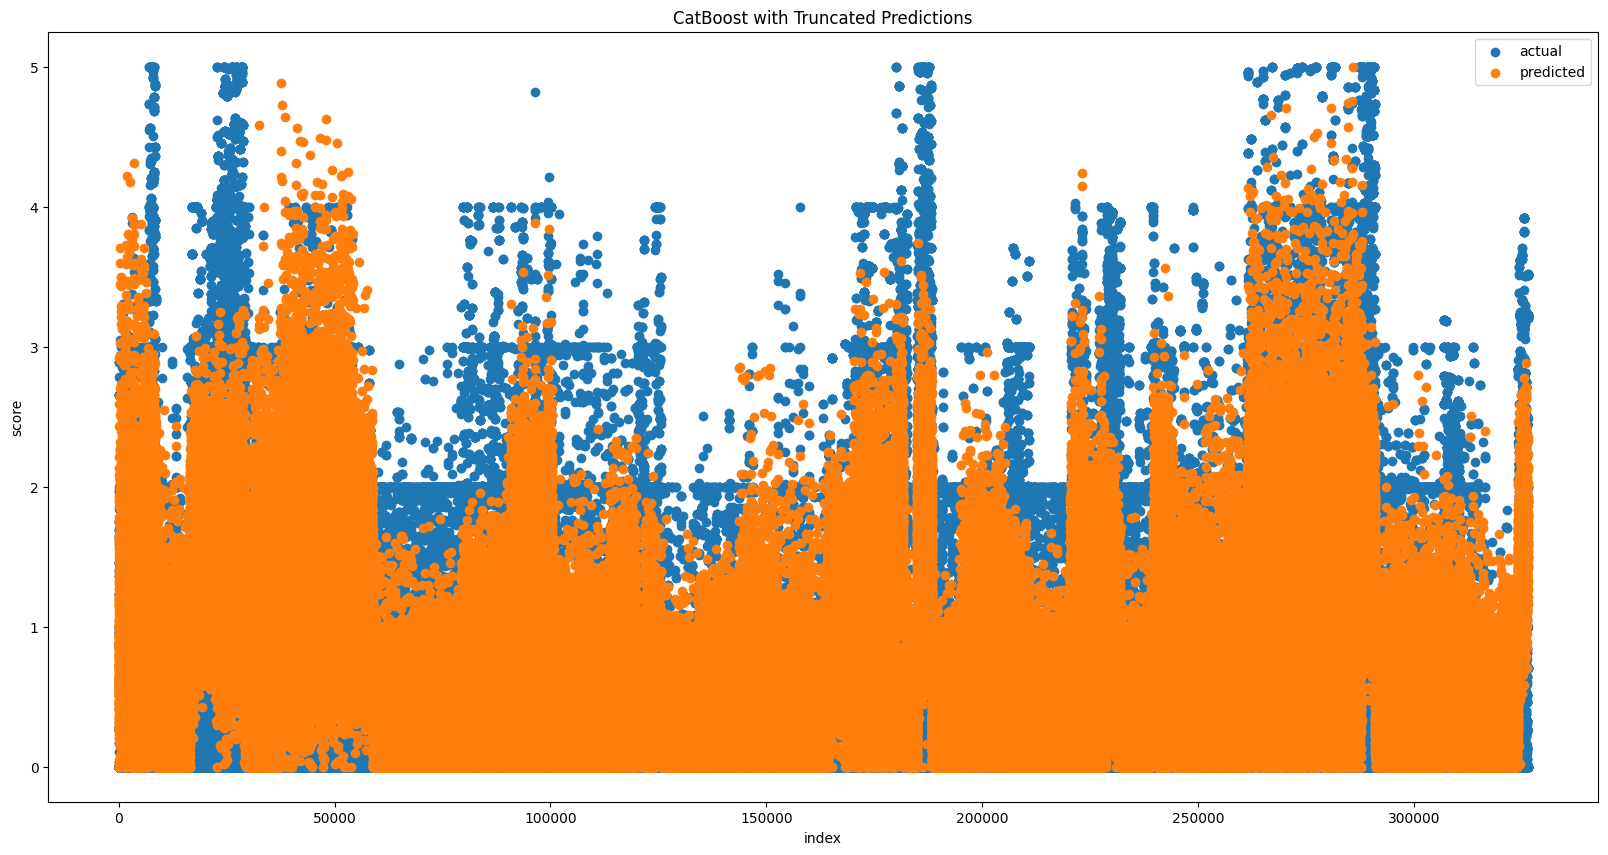

0.7636074288483694

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, model_pred_truncated)
plt.title('CatBoost with Truncated Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')
plt.show()

In [91]:
print("Mean Squared Error: ", mean_squared_error(test['score'], model_pred_truncated))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], model_pred_truncated))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], model_pred_truncated))
print("R2 Score: ", r2_score(test['score'], model_pred_truncated))

Mean Squared Error:  0.7636074288483694
Mean Absolute Error:  0.6671732153364631
Mean Absolute Percentage Error:  1797122017471247.0
R2 Score:  -0.08634024252341277


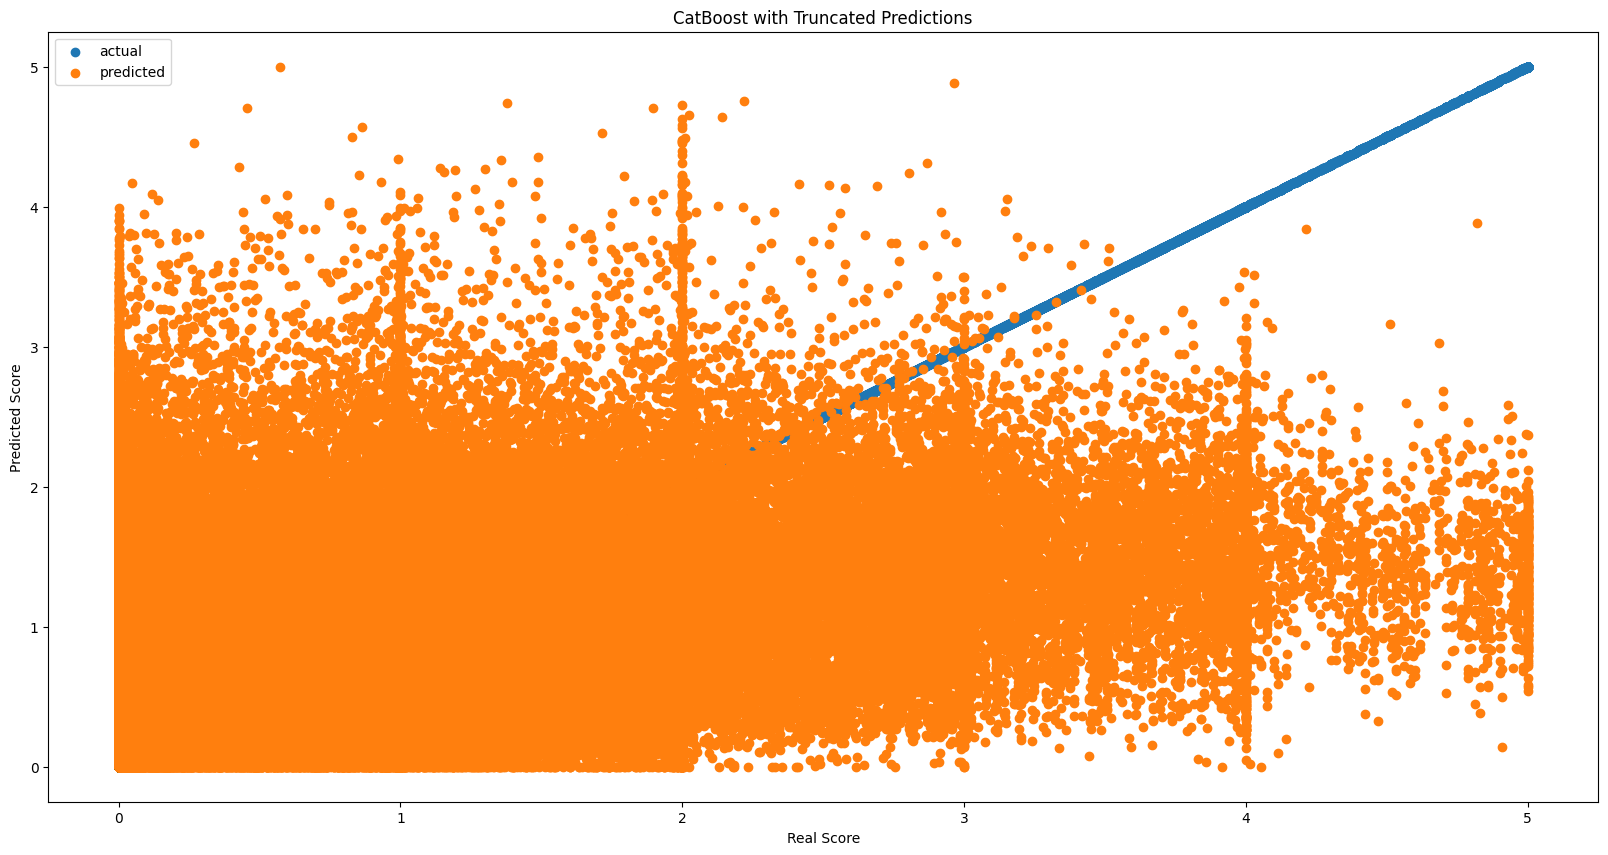

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test['score'], test['score'])
plt.scatter(test['score'], model_pred_truncated)
plt.title('CatBoost with Truncated Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted Score')
plt.show()

The Catboost Regressor has a better MSE score, but does not seem to capture the "shape" of the data as well. The MLP Regressor has a slightly worse MSE metric, but it seems that it is more "willing" to predict a higher score. 

In [52]:
# Element-wise average of the two models predictions

ensemble_pred = (model_pred + mlp_pred) / 2
ensemble_pred_truncated = ensemble_pred.copy()
ensemble_pred_truncated[ensemble_pred_truncated < 0] = 0
ensemble_pred_truncated[ensemble_pred_truncated > 5] = 5

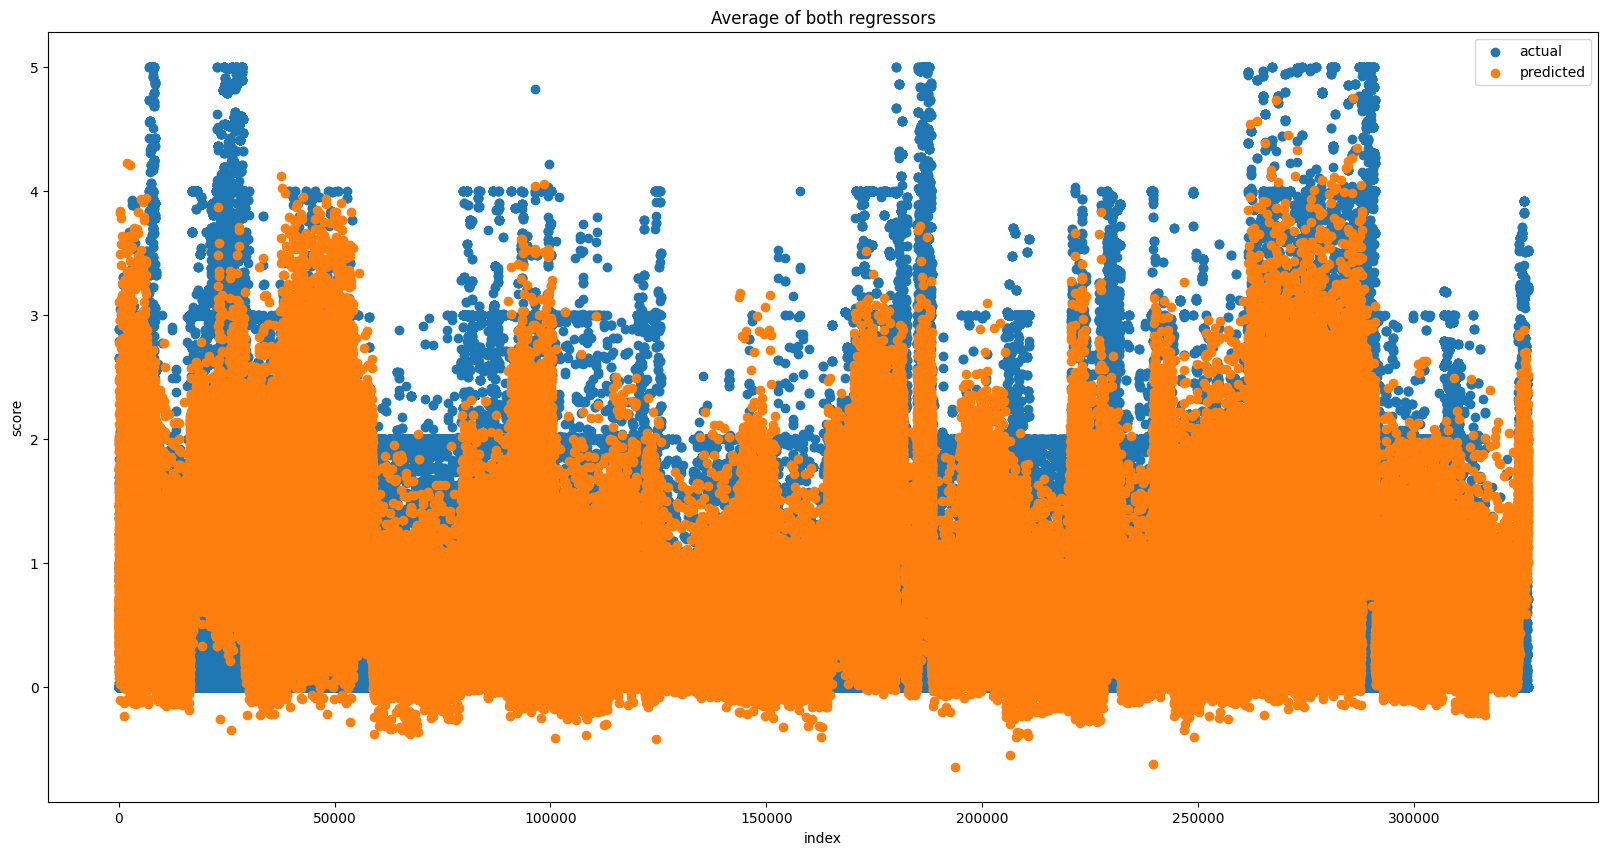

0.7548073286735291

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, ensemble_pred)
plt.title('Average of both regressors')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')
plt.show()

# Check MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test['score'], ensemble_pred)

In [92]:
print("Mean Squared Error: ", mean_squared_error(test['score'], ensemble_pred))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], ensemble_pred))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], ensemble_pred))
print("R2 Score: ", r2_score(test['score'], ensemble_pred))

Mean Squared Error:  0.7548073286735291
Mean Absolute Error:  0.6614544479901435
Mean Absolute Percentage Error:  1766034358397529.0
R2 Score:  -0.07382084761314589


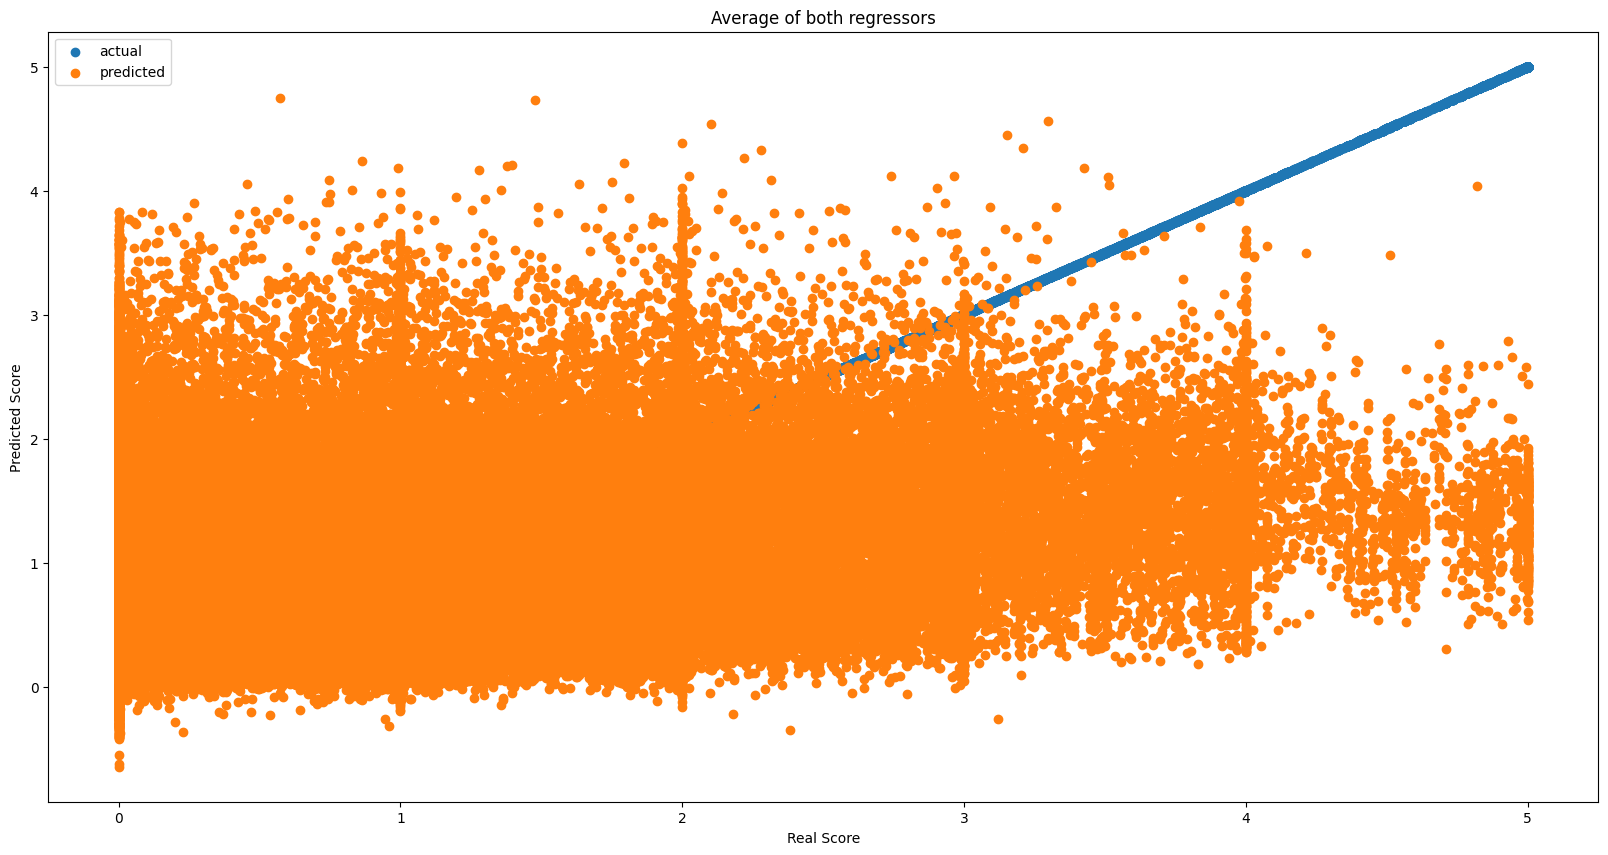

In [111]:
plt.figure(figsize=(20,10))
plt.scatter(test['score'], test['score'])
plt.scatter(test['score'], ensemble_pred)
plt.title('Average of both regressors')
plt.legend(['actual', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted Score')
plt.show()


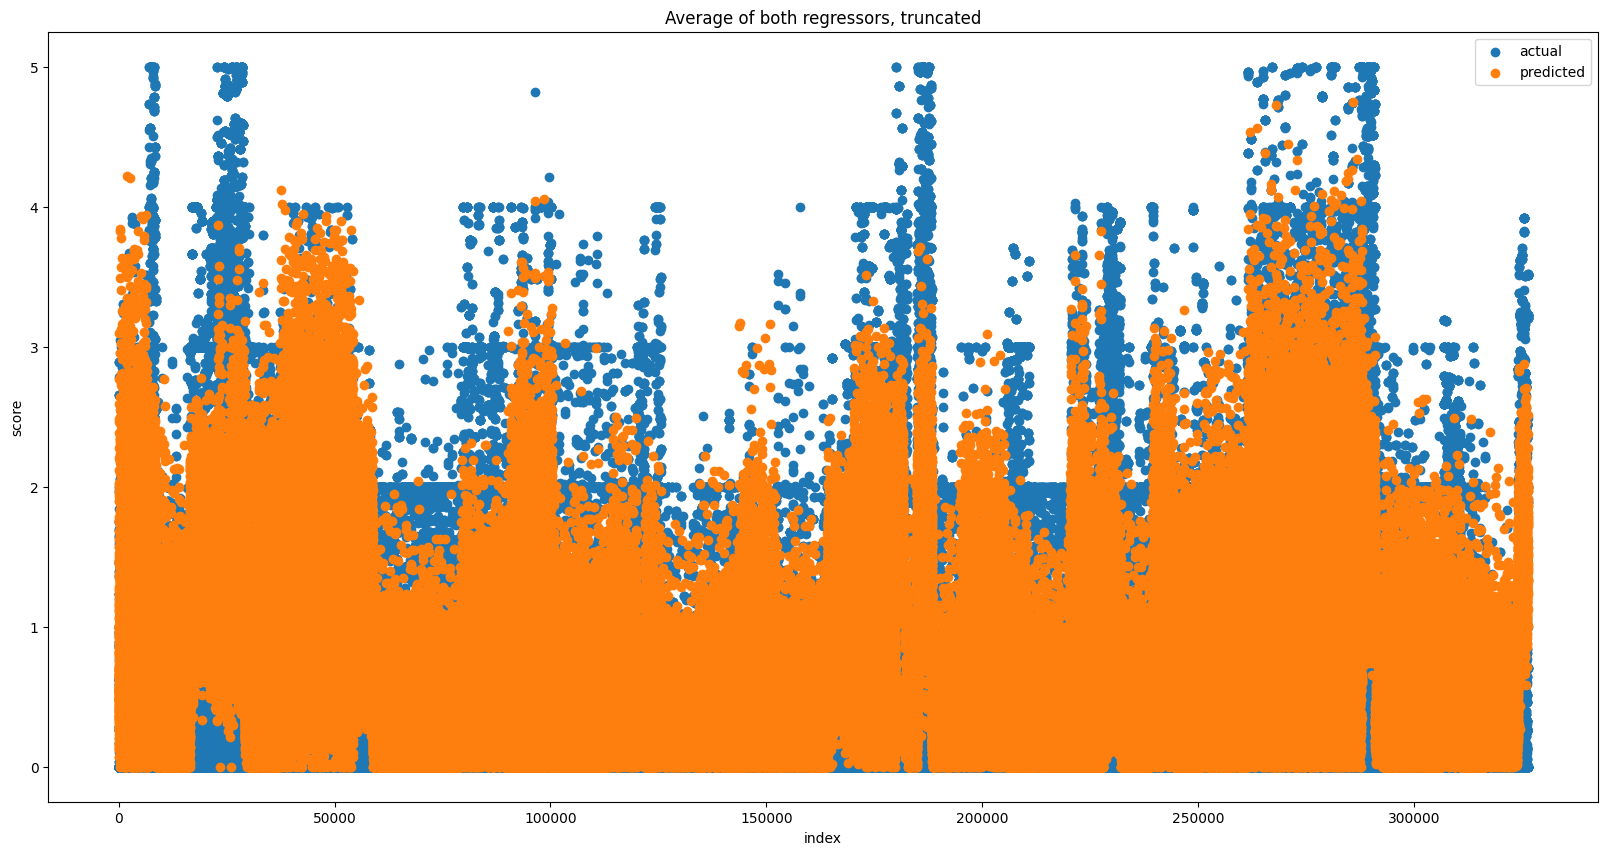

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, test['score'])
plt.scatter(test.index, ensemble_pred_truncated)
plt.title('Average of both regressors, truncated')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')
plt.show()


In [93]:
print("Mean Squared Error: ", mean_squared_error(test['score'], ensemble_pred_truncated))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], ensemble_pred_truncated))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], ensemble_pred_truncated))
print("R2 Score: ", r2_score(test['score'], ensemble_pred_truncated))

Mean Squared Error:  0.7546318404912598
Mean Absolute Error:  0.6607426953814253
Mean Absolute Percentage Error:  1763062056795777.0
R2 Score:  -0.07357119069876261


In [59]:
#make dict of all mse
mse_dict = {
    'ensemble': mean_squared_error(test['score'], ensemble_pred),
    'ensemble_truncated': mean_squared_error(test['score'], ensemble_pred_truncated),
    'catboost': mean_squared_error(test['score'], model_pred),
    'catboost_truncated': mean_squared_error(test['score'], model_pred_truncated),
    'mlp': mean_squared_error(test['score'], mlp_pred),
    'mlp_truncated': mean_squared_error(test['score'], mlp_pred_truncated)
}

#print all elements of mse dict

for key, value in mse_dict.items():
    print(key,"MSE VALUE:", value)

#print min of mse dict
print("MIN MSE VALUE:")
min(mse_dict, key=mse_dict.get)

ensemble MSE VALUE: 0.7548073286735291
ensemble_truncated MSE VALUE: 0.7546318404912598
catboost MSE VALUE: 0.7646419217106
catboost_truncated MSE VALUE: 0.7636074288483694
mlp MSE VALUE: 0.8117843878126008
mlp_truncated MSE VALUE: 0.8082317729812724
MIN MSE VALUE:


'ensemble_truncated'

We do okay on MSE, but our R2 score is absolutely terrible for both of our models. This indicates that the model is achieving a low MSE by being highly biased, and it is not sensitive enough to capture the variance of the data.

Based on the plots of predictions vs real score, as well as our R2 metrics, it seems that we are not capturing the variance of the data as well as we should. While we are generating predictions that are okay on MSE, in order for our model to be robust, we need to do a better job of capturing the variance of the data.

# Attempt 3: Basic preprocessing

First attempt: Scaling data and rounding?

In [126]:
from sklearn.preprocessing import StandardScaler, RobustScaler

train = rounded_train.copy()
test = rounded_test.copy()

train = replace_fips(train)
test = replace_fips(test)

train = train.drop(['date'],axis=1)
traincols = train.columns
test = test.drop(['date'],axis=1)
testcols = test.columns

s = RobustScaler()

train = s.fit_transform(train)
test = s.transform(test)

test = pd.DataFrame(test, columns=testcols)
train = pd.DataFrame(train, columns=traincols)

In [127]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(train.drop(['score'],axis=1),train['score'])

Learning rate set to 0.143141
0:	learn: 1.2176650	total: 296ms	remaining: 4m 55s
1:	learn: 1.2013526	total: 536ms	remaining: 4m 27s
2:	learn: 1.1883131	total: 797ms	remaining: 4m 24s
3:	learn: 1.1780644	total: 1.07s	remaining: 4m 26s
4:	learn: 1.1699315	total: 1.33s	remaining: 4m 25s
5:	learn: 1.1628084	total: 1.6s	remaining: 4m 25s
6:	learn: 1.1573208	total: 1.85s	remaining: 4m 22s
7:	learn: 1.1529937	total: 2.09s	remaining: 4m 19s
8:	learn: 1.1489864	total: 2.31s	remaining: 4m 14s
9:	learn: 1.1458515	total: 2.56s	remaining: 4m 12s
10:	learn: 1.1426705	total: 2.83s	remaining: 4m 14s
11:	learn: 1.1405090	total: 3.06s	remaining: 4m 12s
12:	learn: 1.1382172	total: 3.33s	remaining: 4m 12s
13:	learn: 1.1363263	total: 3.56s	remaining: 4m 10s
14:	learn: 1.1342989	total: 3.83s	remaining: 4m 11s
15:	learn: 1.1328232	total: 4.07s	remaining: 4m 10s
16:	learn: 1.1312919	total: 4.38s	remaining: 4m 13s
17:	learn: 1.1297383	total: 4.66s	remaining: 4m 14s
18:	learn: 1.1284260	total: 4.89s	remaining: 

In [128]:
scaled_pred = model.predict(test.drop(['score'],axis=1))

Mean Squared Error:  0.8962125390696819
Mean Absolute Error:  0.6411104982533554
Mean Absolute Percentage Error:  1939167142365608.2
R2 Score:  -0.21914573427772965


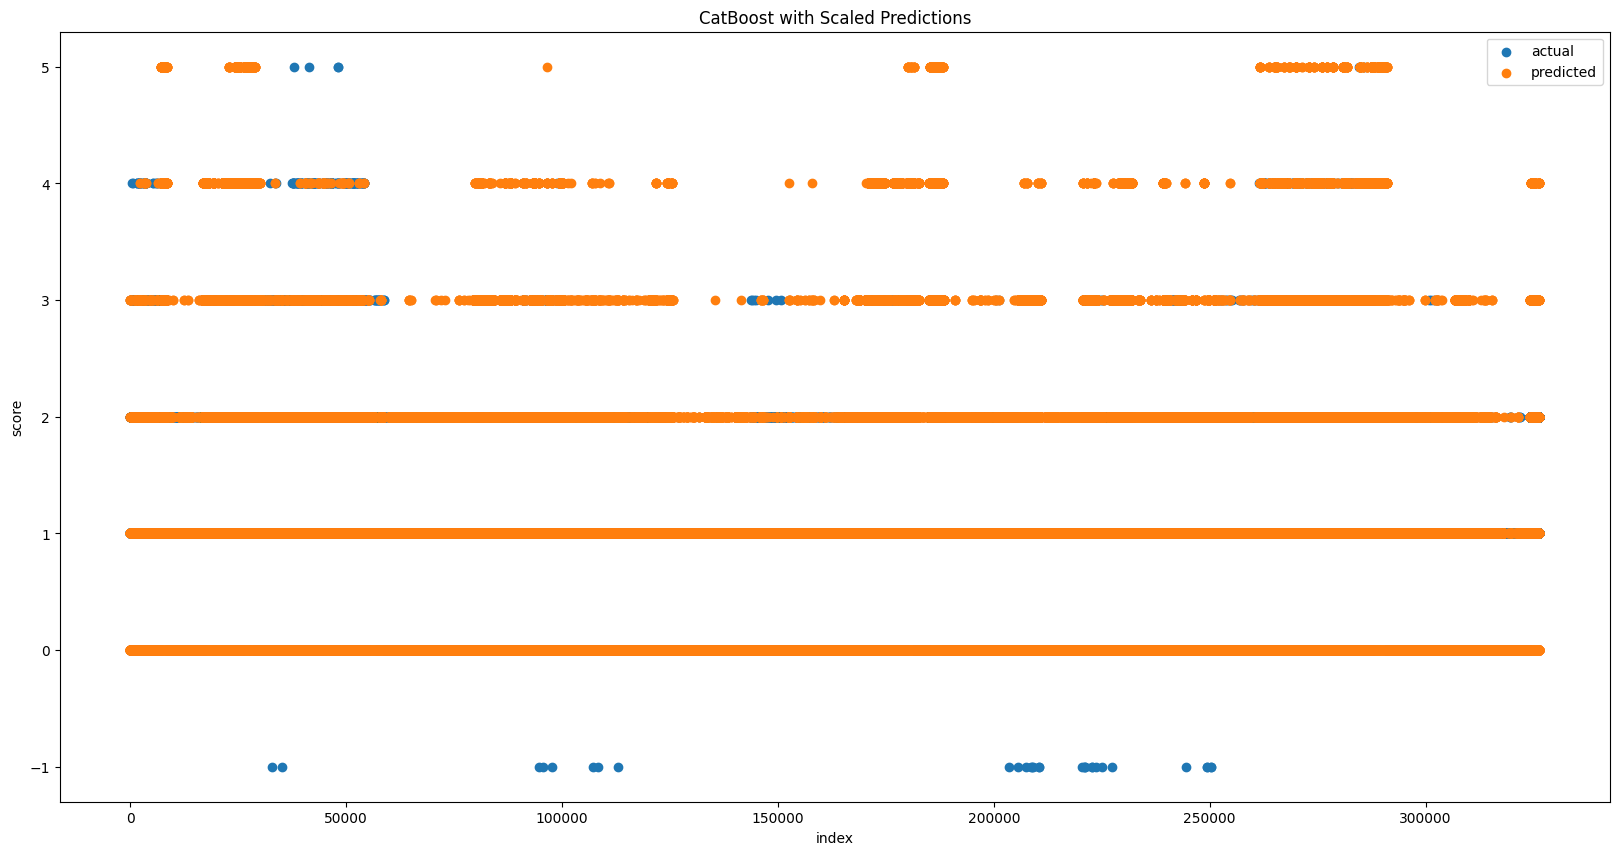

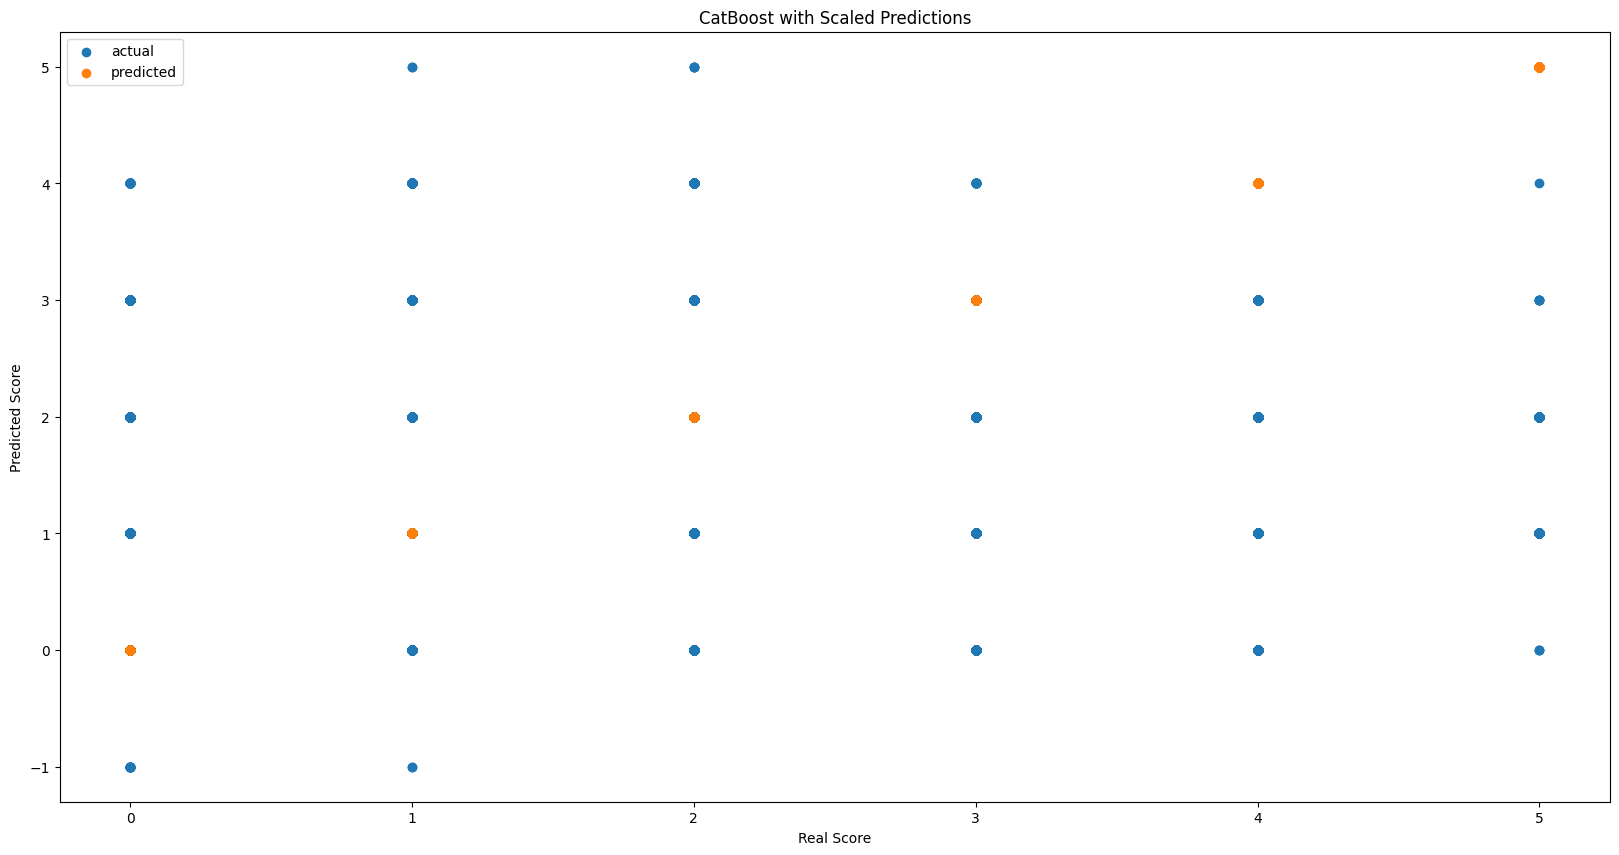

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
print("Mean Squared Error: ", mean_squared_error(test['score'], pd.Series(scaled_pred).round().clip(0,5).astype(int)))
print("Mean Absolute Error: ", mean_absolute_error(test['score'], pd.Series(scaled_pred).round().clip(0,5).astype(int)))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(test['score'], pd.Series(scaled_pred).round().clip(0,5).astype(int)))
print("R2 Score: ", r2_score(test['score'], pd.Series(scaled_pred).round().clip(0,5).astype(int)))

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(test.index, pd.Series(scaled_pred).round())
plt.scatter(test.index, test['score'])
plt.title('CatBoost with Scaled Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('index')
plt.ylabel('score')
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(test['score'], pd.Series(scaled_pred).round())
plt.scatter(test['score'], test['score'])
plt.title('CatBoost with Scaled Predictions')
plt.legend(['actual', 'predicted'])
plt.xlabel('Real Score')
plt.ylabel('Predicted Score')
plt.show()

# Mid-Experiment Analysis

Our MSE is likely only good because the data is heavily concentrated towards the mean. Our R2 value is extremely poor, and I don't think there's a way to rectify this without considering the time-series nature of the data. We also likely need to change the models that we are using. Decision Tree based regression may not be the best move, and an MLP might be better suited to this. 

One thought about incorporating time-series data is as follows. We could use the previous 4 weeks of known truth labels as features, and make the target the score for the next week. At training time, all of the data points would be known. At test time, I'm not sure whether we'd have to "roll" our predictions (ie. use our predictions for one week as a feature for the next week), or if we can assume the existence of a truth label as soon as the week actually occurs (some hypothetical empirical calculation that is determined by someone else?). I'm going to work off of the second assumption, as it makes it somewhat easier to handle.

# Time-Series data manipulation

- Encode Lag features (ground truth of drought score) from 4 weeks previous
- Make target variable the score for X weeks out

In [3]:
train = raw_train.copy()
test = raw_test.copy()

trainfips = train['fips']
testfips = test['fips']

train = replace_fips(train)
test = replace_fips(test)

train = pd.concat([train, trainfips], axis=1)
test = pd.concat([test, testfips], axis=1)

train.head()

,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,lat,long,fips
0,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,2.08,3.59,6.73,9.31,3.74,5.58,1.0,32.532237,-86.64644,1001
1,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,...,1.05,1.43,3.55,6.38,1.71,4.67,2.0,32.532237,-86.64644,1001
2,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,...,1.67,1.92,5.19,6.40,3.84,2.55,2.0,32.532237,-86.64644,1001
3,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,...,2.28,2.32,5.75,8.03,3.96,4.07,2.0,32.532237,-86.64644,1001
4,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,...,0.88,1.86,4.18,6.38,1.27,5.11,1.0,32.532237,-86.64644,1001


In [ ]:
NUM_WEEKS_OF_CONTEXT = 4

In [17]:
def add_lag_features(num_weeks:int,column:str,groupby:str, df:pd.DataFrame)->pd.DataFrame:
    '''This convenience function lags the column by num_weeks after grouping by groupby'''
    for i in(range(1,num_weeks+1)):
        df[f'{column}_lag{i}'] = df.groupby([groupby])[column].shift(i)
    return df

In [19]:
def regression_metric(y_true,y_pred, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20,10))
    plt.scatter(y_true, y_true)
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.legend(['actual', 'predicted'])
    plt.xlabel('Real Index')
    plt.ylabel('Predicted Score')
    plt.show()

    # Check MSE
    from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
    print("Mean Squared Error: ", mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_true, y_pred))
    print("R2 Score: ", r2_score(y_true, y_pred))



In [4]:
# add 4 weeks worth of context
train.set_index('date',inplace=True)
train['score_lag_1'] = train.groupby(['fips'])['score'].shift(1)
train['score_lag_2'] = train.groupby(['fips'])['score'].shift(2)
train['score_lag_3'] = train.groupby(['fips'])['score'].shift(3)
train['score_lag_4'] = train.groupby(['fips'])['score'].shift(4)
train.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_MIN,WS50M_RANGE,score,lat,long,fips,score_lag_1,score_lag_2,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,...,3.74,5.58,1.0,32.532237,-86.64644,1001,NaN,NaN,NaN,NaN
2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,10.43,...,1.71,4.67,2.0,32.532237,-86.64644,1001,1.0,NaN,NaN,NaN
2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,14.19,...,3.84,2.55,2.0,32.532237,-86.64644,1001,2.0,1.0,NaN,NaN
2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,-0.61,...,3.96,4.07,2.0,32.532237,-86.64644,1001,2.0,2.0,1.0,NaN
2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,...,1.27,5.11,1.0,32.532237,-86.64644,1001,2.0,2.0,2.0,1.0


In [5]:
test.set_index('date', inplace=True)
test['score_lag_1'] = test.groupby(['fips'])['score'].shift(1)
test['score_lag_2'] = test.groupby(['fips'])['score'].shift(2)
test['score_lag_3'] = test.groupby(['fips'])['score'].shift(3)
test['score_lag_4'] = test.groupby(['fips'])['score'].shift(4)
test.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS50M_MIN,WS50M_RANGE,score,lat,long,fips,score_lag_1,score_lag_2,score_lag_3,score_lag_4
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,...,1.23,2.78,0.0,32.532237,-86.64644,1001,NaN,NaN,NaN,NaN
2019-01-08,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,...,3.67,2.85,0.0,32.532237,-86.64644,1001,0.0,NaN,NaN,NaN
2019-01-15,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,...,2.39,1.75,0.0,32.532237,-86.64644,1001,0.0,0.0,NaN,NaN
2019-01-22,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,...,5.01,3.55,0.0,32.532237,-86.64644,1001,0.0,0.0,0.0,NaN
2019-01-29,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,...,3.60,3.35,0.0,32.532237,-86.64644,1001,0.0,0.0,0.0,0.0


I've added the previous 4 weeks worth of ground truth as features for the regressor. I now need to make the target variable the score for X weeks out. I'm going to start with a 1-week ahead forecasting approach and see how that works.

In [6]:
NUM_WEEKS_TO_FORECAST = 1

In [7]:
train['score'] = train.groupby(['fips'])['score'].shift(-1*NUM_WEEKS_TO_FORECAST)
test['score'] = test.groupby(['fips'])['score'].shift(-1*NUM_WEEKS_TO_FORECAST)

In [8]:
train.drop(['fips'],axis=1,inplace=True)
test.drop(['fips'],axis=1,inplace=True)

In [9]:
train.isna().sum()

PRECTOT            0
PS                 0
QV2M               0
T2M                0
T2MDEW             0
T2MWET             0
T2M_MAX            0
T2M_MIN            0
T2M_RANGE          0
TS                 0
WS10M              0
WS10M_MAX          0
WS10M_MIN          0
WS10M_RANGE        0
WS50M              0
WS50M_MAX          0
WS50M_MIN          0
WS50M_RANGE        0
score           3108
lat                0
long               0
score_lag_1     3108
score_lag_2     6216
score_lag_3     9324
score_lag_4    12432
dtype: int64

In [10]:
test.isna().sum()

PRECTOT            0
PS                 0
QV2M               0
T2M                0
T2MDEW             0
T2MWET             0
T2M_MAX            0
T2M_MIN            0
T2M_RANGE          0
TS                 0
WS10M              0
WS10M_MAX          0
WS10M_MIN          0
WS10M_RANGE        0
WS50M              0
WS50M_MAX          0
WS50M_MIN          0
WS50M_RANGE        0
score           3108
lat                0
long               0
score_lag_1     3108
score_lag_2     6216
score_lag_3     9324
score_lag_4    12432
dtype: int64

Shifting the values to create the lags and to make the target variable added some NaN values to the data. I'm going to drop these.

In [11]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [12]:
train.isna().sum()

PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
lat            0
long           0
score_lag_1    0
score_lag_2    0
score_lag_3    0
score_lag_4    0
dtype: int64

In [13]:
test.isna().sum()

PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
lat            0
long           0
score_lag_1    0
score_lag_2    0
score_lag_3    0
score_lag_4    0
dtype: int64

Now, I'm going to try the same catboostregressor as before, but with the lag features now added.

In [14]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(train.drop(['score'],axis=1),train['score'])

Learning rate set to 0.143013
0:	learn: 1.0727712	total: 380ms	remaining: 6m 19s
1:	learn: 0.9450841	total: 677ms	remaining: 5m 38s
2:	learn: 0.8385359	total: 939ms	remaining: 5m 12s
3:	learn: 0.7503839	total: 1.18s	remaining: 4m 54s
4:	learn: 0.6772832	total: 1.44s	remaining: 4m 46s
5:	learn: 0.6178968	total: 1.69s	remaining: 4m 39s
6:	learn: 0.5699884	total: 1.95s	remaining: 4m 36s
7:	learn: 0.5311350	total: 2.21s	remaining: 4m 34s
8:	learn: 0.5004336	total: 2.46s	remaining: 4m 31s
9:	learn: 0.4765100	total: 2.72s	remaining: 4m 29s
10:	learn: 0.4575828	total: 2.97s	remaining: 4m 26s
11:	learn: 0.4430119	total: 3.21s	remaining: 4m 24s
12:	learn: 0.4315881	total: 3.47s	remaining: 4m 23s
13:	learn: 0.4226255	total: 3.71s	remaining: 4m 21s
14:	learn: 0.4157649	total: 3.96s	remaining: 4m 20s
15:	learn: 0.4106562	total: 4.21s	remaining: 4m 19s
16:	learn: 0.4063869	total: 4.47s	remaining: 4m 18s
17:	learn: 0.4033354	total: 4.74s	remaining: 4m 18s
18:	learn: 0.4009007	total: 4.97s	remaining:

In [15]:
preds = model.predict(test.drop(['score'],axis=1))

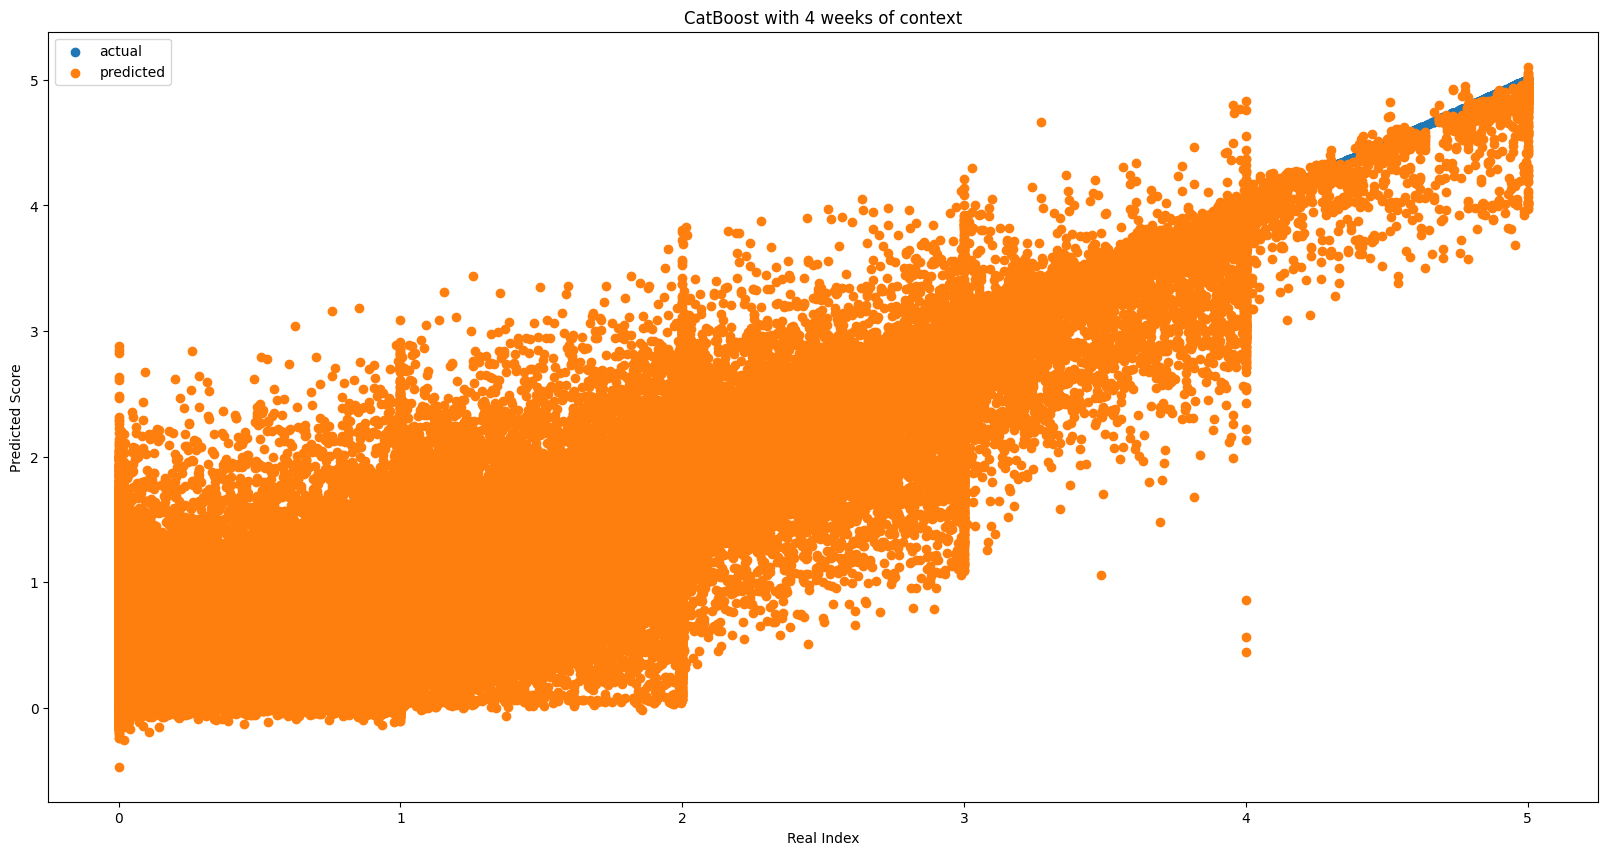

Mean Squared Error:  0.10298512832055014
Mean Absolute Error:  0.17302552702864524
Mean Absolute Percentage Error:  246714846078534.28
R2 Score:  0.8554472329258824


In [21]:
regression_metric(test['score'], preds, 'CatBoost with 4 weeks of context')

In [ ]:
# save time-series catboost regressor
import pickle
pickle.dump(model, open('catboost_time_series_regressor_4-1', 'wb'))

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_1,73.051489
1,long,3.611388
2,PRECTOT,3.317619
3,T2M_MAX,2.917899
4,QV2M,2.105821
5,lat,1.936232
6,score_lag_2,1.754923
7,TS,1.437189
8,T2M_MIN,1.336508
9,T2M_RANGE,1.272088


We can see that the lag score of 1 week is the highest weighted feature. This makes sense, as it is unlikely that the drought score will change drastically in a week. We can also see that certain climate features are actually more important than some score lag features. This is interesting, and may indicate that we can use the lagging climate features to predict the drought score without using the lag scores.

In [20]:
train = train.drop(['score_lag_1'],axis=1)
test = test.drop(['score_lag_1'],axis=1)

model2 = CatBoostRegressor()
model2.fit(train.drop(['score'],axis=1),train['score'])

Learning rate set to 0.143013
0:	learn: 1.0828753	total: 237ms	remaining: 3m 57s
1:	learn: 0.9647934	total: 491ms	remaining: 4m 5s
2:	learn: 0.8675752	total: 740ms	remaining: 4m 5s
3:	learn: 0.7875656	total: 1.01s	remaining: 4m 10s
4:	learn: 0.7222130	total: 1.27s	remaining: 4m 13s
5:	learn: 0.6700403	total: 1.55s	remaining: 4m 16s
6:	learn: 0.6286197	total: 1.82s	remaining: 4m 18s
7:	learn: 0.5954876	total: 2.09s	remaining: 4m 19s
8:	learn: 0.5695391	total: 2.37s	remaining: 4m 21s
9:	learn: 0.5494706	total: 2.66s	remaining: 4m 23s
10:	learn: 0.5338861	total: 2.94s	remaining: 4m 23s
11:	learn: 0.5218936	total: 3.24s	remaining: 4m 26s
12:	learn: 0.5123059	total: 3.5s	remaining: 4m 25s
13:	learn: 0.5047412	total: 3.76s	remaining: 4m 24s
14:	learn: 0.4989632	total: 4.01s	remaining: 4m 23s
15:	learn: 0.4944670	total: 4.26s	remaining: 4m 22s
16:	learn: 0.4909206	total: 4.53s	remaining: 4m 21s
17:	learn: 0.4881236	total: 4.78s	remaining: 4m 20s
18:	learn: 0.4859940	total: 5.03s	remaining: 4m

In [22]:
model2preds = model2.predict(test.drop(['score'],axis=1))

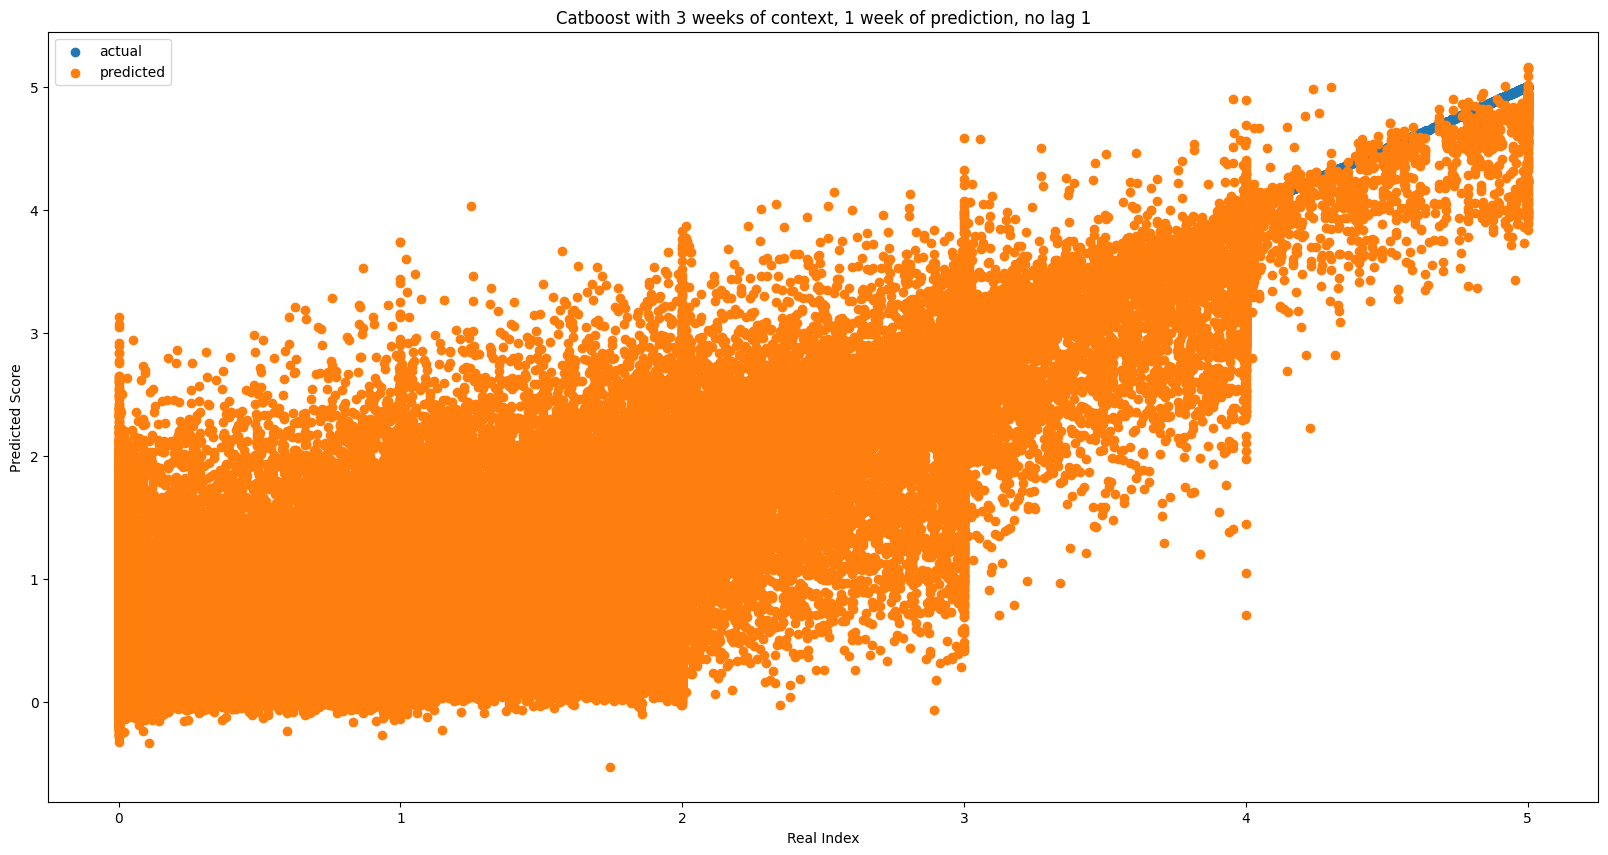

Mean Squared Error:  0.15530057632055197
Mean Absolute Error:  0.2263361569720815
Mean Absolute Percentage Error:  350195001666078.0
R2 Score:  0.7820158269311847


In [23]:
regression_metric(test['score'], model2preds, 'Catboost with 3 weeks of context, 1 week of prediction, no lag 1')

Performance does take a hit, but not a super severe hit without the immediate previous week's measurement as a lag feature. I imagine that a more advanced regressor could make up for the performance loss.

In [24]:
model2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,score_lag_2,64.118488
1,long,5.472153
2,T2M_MAX,4.053100
3,QV2M,2.851369
4,lat,2.786362
5,TS,2.469800
6,PRECTOT,2.424313
7,T2M_MIN,2.374137
8,T2M_RANGE,2.145675
9,score_lag_3,1.881864
